In [1]:
#!/usr/bin/env python
# coding: utf-8

# Disabling any minor warmings and logs
import warnings
warnings.filterwarnings("ignore")

In [2]:
import h5py
import numpy as np
from numpy import concatenate

import pandas as pd
from pandas import read_csv, concat, DataFrame

from math import sqrt
import tensorflow as tf
from matplotlib import pyplot
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error

from keras import callbacks
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Conv1D, LSTM, GRU
from keras.callbacks import ModelCheckpoint, CSVLogger

Using TensorFlow backend.


In [3]:
dataset = read_csv("power_consumption.csv",
                   parse_dates={'dt' : ['Date', 'Time']},
                   infer_datetime_format=True, 
                   index_col= 0,
                   na_values=['nan','?'])
dataset.fillna(0, inplace=True)
values = dataset.values
values = values.astype('float32')

In [4]:
print(dataset.head(3))

                     Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   

                     Sub_metering_3  
dt                                   
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  


In [5]:
# normalizing input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled = pd.DataFrame(scaled)

In [6]:
print(scaled.head(3))

          0         1         2         3    4         5     6
0  0.389173  0.478261  0.402339  0.391304  0.0  0.012821  0.85
1  0.497445  0.498856  0.359447  0.491304  0.0  0.012821  0.80
2  0.498770  0.569794  0.347394  0.491304  0.0  0.025641  0.85


In [7]:
def create_ts_data(dataset, lookback=1, predicted_col=1):
    temp=dataset.copy()
    temp["id"]= range(1, len(temp)+1)
    temp = temp.iloc[:-lookback, :]
    temp.set_index('id', inplace =True)
    predicted_value=dataset.copy()
    predicted_value = predicted_value.iloc[lookback:,predicted_col]
    predicted_value.columns=["Predcited"]
    predicted_value= pd.DataFrame(predicted_value)
    
    predicted_value["id"]= range(1, len(predicted_value)+1)
    predicted_value.set_index('id', inplace =True)
    final_df= pd.concat([temp, predicted_value], axis=1)
    return final_df

In [8]:
reframed_df= create_ts_data(scaled, 1,0)
reframed_df.fillna(0, inplace=True)
reframed_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)','var1(t)']

In [9]:
print(reframed_df.head(4))

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
id                                                                     
1    0.389173   0.478261   0.402339   0.391304        0.0   0.012821   
2    0.497445   0.498856   0.359447   0.491304        0.0   0.012821   
3    0.498770   0.569794   0.347394   0.491304        0.0   0.025641   
4    0.500095   0.574371   0.363347   0.491304        0.0   0.012821   

    var7(t-1)   var1(t)  
id                       
1        0.85  0.497445  
2        0.80  0.498770  
3        0.85  0.500095  
4        0.85  0.337119  


In [10]:
# split into train and test sets
values = reframed_df.values
training_sample =int( len(dataset) *0.7)
train = values[:training_sample, :]
test = values[training_sample:, :]

In [11]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [12]:
# reshape input to be 3D [samples, time steps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [13]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(133347, 1, 7) (133347,) (57149, 1, 7) (57149,)


In [14]:
model = Sequential()
model.add(LSTM(80, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(units=100, return_sequences=True))
model.add(LSTM(units=120, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=120, return_sequences=True))
model.add(LSTM(units=80, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=40))
model.add(Dense(units=1))
model.compile(loss='mae', optimizer='adam')

W0828 10:24:12.404101 140476860671616 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0828 10:24:12.460202 140476860671616 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0828 10:24:12.469505 140476860671616 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0828 10:24:13.273775 140476860671616 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0828 10:24:13.288887 140476860671616 deprecat

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 80)             28160     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 100)            72400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 120)            106080    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 120)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 120)            115680    
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 80)             64320     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 80)            

In [16]:
checkpointer = callbacks.ModelCheckpoint(filepath="Model/checkpoint-{epoch:02d}.hdf5", verbose=1, save_best_only=True, monitor='val_acc',mode='max')
csv_logger = CSVLogger('Model/model.csv',separator=',', append=False)

In [17]:
# fit network
model_= model.fit(train_X, train_y, epochs=80, batch_size=64, 
                              validation_data=(test_X, test_y), shuffle=False,
                                     callbacks=[checkpointer,csv_logger])

W0828 10:24:15.344160 140476860671616 deprecation.py:323] From /usr/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0828 10:24:20.574129 140476860671616 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 133347 samples, validate on 57149 samples
Epoch 1/80
133347/133347 [==============================] - 53s 400us/step - loss: 0.0433 - val_loss: 0.0155
Epoch 2/80
133347/133347 [==============================] - 53s 397us/step - loss: 0.0218 - val_loss: 0.0156
Epoch 3/80
133347/133347 [==============================] - 34s 255us/step - loss: 0.0203 - val_loss: 0.0178
Epoch 4/80
133347/133347 [==============================] - 34s 254us/step - loss: 0.0191 - val_loss: 0.0114
Epoch 5/80
133347/133347 [==============================] - 41s 306us/step - loss: 0.0188 - val_loss: 0.0158
Epoch 6/80
133347/133347 [==============================] - 53s 398us/step - loss: 0.0187 - val_loss: 0.0107
Epoch 7/80
133347/133347 [==============================] - 35s 266us/step - loss: 0.0176 - val_loss: 0.0124
Epoch 8/80
133347/133347 [==============================] - 31s 233us/step - loss: 0.0185 - val_loss: 0.0119
Epoch 9/80
133347/133347 [==============================] - 32s 236us/step - 

133347/133347 [==============================] - 42s 318us/step - loss: 0.0140 - val_loss: 0.0084
Epoch 76/80
133347/133347 [==============================] - 41s 308us/step - loss: 0.0140 - val_loss: 0.0082
Epoch 77/80
133347/133347 [==============================] - 44s 331us/step - loss: 0.0139 - val_loss: 0.0085
Epoch 78/80
133347/133347 [==============================] - 45s 340us/step - loss: 0.0139 - val_loss: 0.0082
Epoch 79/80
133347/133347 [==============================] - 40s 301us/step - loss: 0.0140 - val_loss: 0.0085
Epoch 80/80
133347/133347 [==============================] - 41s 306us/step - loss: 0.0140 - val_loss: 0.0086


In [18]:
model.save("Model/model.hdf5")
print("Final model saved successfully!")

Final model saved successfully!


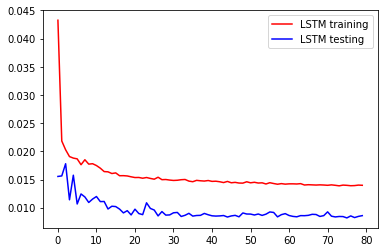

In [19]:
pyplot.plot(model_.history['loss'], label='LSTM training', color='red')
pyplot.plot(model_.history['val_loss'], label='LSTM testing', color= 'blue')
pyplot.legend()
pyplot.savefig(fname='Graph/LSTM loss chart.png', dpi = 400)
pyplot.show()